# Prediction of CO2 Emission per Country
## Pappo, Katz, Pimenta Silva, Tuncel

### Importing and Downloading

In [20]:
import numpy as np
import pandas as pd

In [73]:
df_CO2_brut = pd.read_csv('data/GCB2022v27_MtCo2_flat.csv')
# df_CO2

In [74]:
df_GEI_brut = pd.read_csv('data/Global Economy Indicators.csv')
# df_GEI_brut

### Cleaning the datasets

In [128]:
# Drop rows where year is less than 1970
df_CO2 = df_CO2_brut.drop(df_CO2_brut[df_CO2_brut['Year'] < 1970].index)

df_CO2 = df_CO2.drop(columns=['ISO 3166-1 alpha-3'])

# Replace NaN values with 0
df_CO2 = df_CO2.replace(np.nan, 0)

# Delete spaces in column names
df_CO2.columns = df_CO2.columns.str.strip()

df_CO2.reset_index(drop=True, inplace=True)
# df_CO2.head()

In [139]:
# Drop columns that are not needed
df_GEI = df_GEI_brut.drop(columns=[
    ' Currency ',
    ' AMA exchange rate ', 
    ' IMF based exchange rate ', 
    ' Changes in inventories ', 
    ' Other Activities (ISIC J-P) '])

# Delete spaces in column names
df_GEI.columns = df_GEI.columns.str.strip()

# Delete spaces in Country names
df_GEI['Country'] = df_GEI['Country'].str.strip()

df_GEI.reset_index(drop=True, inplace=True)
# df_GEI.head()

In [161]:
# Rename columns
df_GEI.rename(columns={
    'Agriculture, hunting, forestry, fishing (ISIC A-B)': 'Agriculture & Fishing',
    'Construction (ISIC F)': 'Construction',
    'Exports of goods and services': 'Exports',
    'Final consumption expenditure': 'Final Consumption',
    'General government final consumption expenditure': 'Gov. Consumption',
    'Gross capital formation': 'Gross Capital Formation',
    'Gross fixed capital formation (including Acquisitions less disposals of valuables)': 'Gross Fixed Capital',
    'Household consumption expenditure (including Non-profit institutions serving households)': 'Household Consumption',
    'Imports of goods and services': 'Imports',
    'Manufacturing (ISIC D)': 'Manufacturing',
    'Mining, Manufacturing, Utilities (ISIC C-E)': 'Mining & Utilities',
    'Total Value Added': 'Total Value Added',
    'Transport, storage and communication (ISIC I)': 'Transport & Comm.',
    'Wholesale, retail trade, restaurants and hotels (ISIC G-H)': 'Wholesale & Retail',
    'Gross National Income(GNI) in USD': 'GNI (USD)',
    'Gross Domestic Product (GDP)': 'GDP',
    'Total': 'Total'
}, inplace=True)

### Merging Datasets

In [164]:
# Merge the two dataframes on 'Country' and 'Year'
df = df_GEI.merge(df_CO2, on=['Country', 'Year'])

# Drop column Country, as we already have the ID
df.drop(columns=['Country'], inplace=True)
# df.head()

### Vizualisation

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt

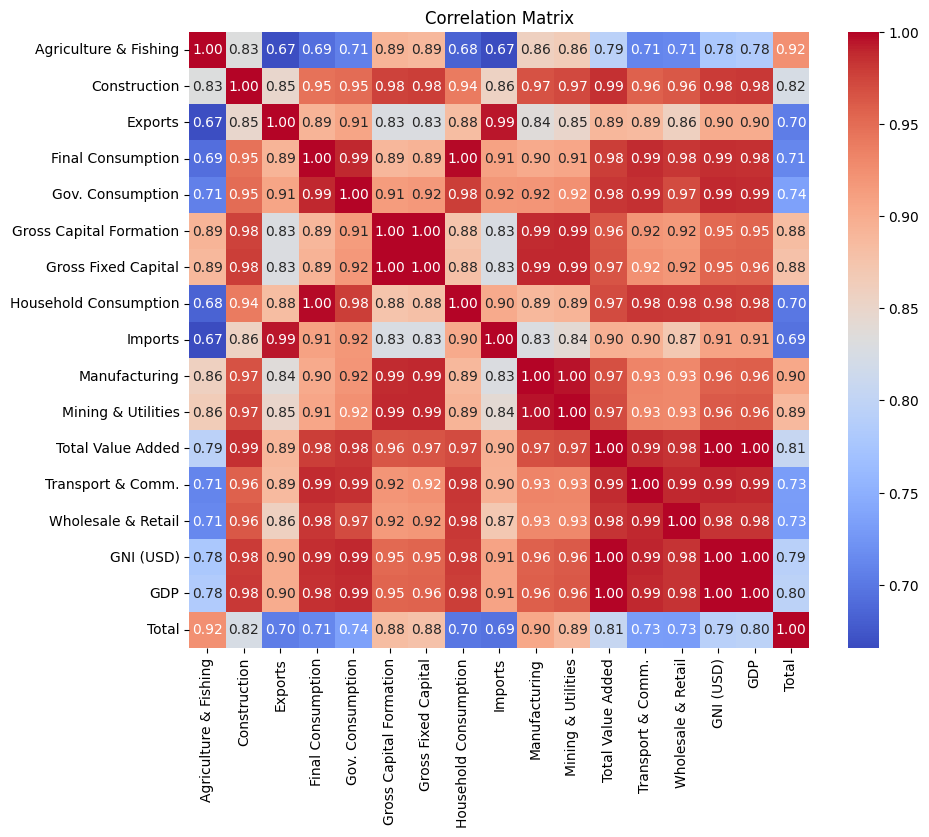

In [163]:
df_corr = df[[
    'Agriculture & Fishing',
    'Construction',
    'Exports',
    'Final Consumption',
    'Gov. Consumption',
    'Gross Capital Formation',
    'Gross Fixed Capital',
    'Household Consumption',
    'Imports', 
    'Manufacturing',
    'Mining & Utilities', 
    'Transport & Comm.',
    'Wholesale & Retail',
    'GNI (USD)', 
    'GDP',
    'Total']].corr()

plt.figure(figsize=(10, 8))  # Définir la taille de la figure
sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title("Correlation Matrix")
plt.show()